In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from ISLP.models import summarize, ModelSpec as MS

In [2]:
auto = pd.read_csv('../datasets/Auto.csv', na_values=['?'])
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [3]:
# drop nans
auto = auto.dropna()

In [4]:
y = auto['mpg']
X = pd.DataFrame({
    'intercept': np.ones(auto.shape[0]),
    'horsepower': auto['horsepower']
})

model = sm.OLS(y, X)

# Fit the model
results = model.fit()

In [5]:
summarize(results)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [14]:
print(results.summary2())

# Scale: A scale factor for the covariance matrix. 
# The Default value is ssr/(n-p). Note that the square root of scale is often called the standard error of the regression.
# SSR is sum of squared residuals (residual sum of squares, RSS)
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.scale.html#statsmodels.regression.linear_model.OLSResults.scale

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.605    
Dependent Variable: mpg              AIC:                2361.3237
Date:               2023-12-21 11:25 BIC:                2369.2662
No. Observations:   392              Log-Likelihood:     -1178.7  
Df Model:           1                F-statistic:        599.7    
Df Residuals:       390              Prob (F-statistic): 7.03e-81 
R-squared:          0.606            Scale:              24.066   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
intercept     39.9359    0.7175   55.6598  0.0000  38.5252  41.3465
horsepower    -0.1578    0.0064  -24.4891  0.0000  -0.1705  -0.1452
------------------------------------------------------------------
Omnibus:               16.432       Durbin-Watson:          0.920 
Prob(Omn

In [17]:
y_mean = sum(y)/len(y)
y_mean

23.44591836734694

## Is there a relationship between the predictor and the response?
Since the p-value for the coefficient is close to 0, there is a relashionship between the predictor (horsepower) and the response (mpg)

## How strong is the relationship between the predictor and the response?
The Residual Standard Error is:

$$RSE = \sqrt{\frac{RSS}{n-p-1}}$$

This is an estimate of the standard deviation of $\epsilon$. The average amount that the response $y$ will deviate from the true regression line.

In the results table, we get the parameter *Scale*, which is $RSE^2$. Then,

$$RSE = \sqrt{24.066} = 4.906$$

Dividing this result by the mean of *y*:

$$\frac{RSE}{\bar{y}} = \frac{4.906}{23.4459} = 0.2092$$

This is, the percent error is 20.92%.

The $R^2$ is 0.605, which is 60.5%. This is the percentage of variability in the response (mpg) that is explained by the predictor (horsepower). Then, horsepower explains 60.5% of the variance in mpg.

## Is the relationship between the predictor and the response positive or negative?
The relashionship is negative, because the parameter is negative (-0.1578). This means that when horsepower increases, mpg decreases.

## What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?
$$mpg = 39.9359 - 0.1578\times horsepower$$

When horsepower is 98:

$$mpg = 39.9359 - 0.1578\times 98 = 24.4715$$

To make predictions, the `results` object can be used with the `predict` method: `results.predict((1, 98))`, or `results.predict([1, 98])`.

For the confidence interval, use `new_predictions.conf_int(alpha=0.05)`: `[23.97307896, 24.96107534]`.

For the prediction interval, use `new_predictions.conf_int(obs=True, alpha=0.05)`: `[14.80939607, 34.12475823]`.

The prediction interval is wider than the confidence interval.

In [7]:
results.predict((1, 98))

array([24.46707715])

In [26]:
intercept, slope = results.params

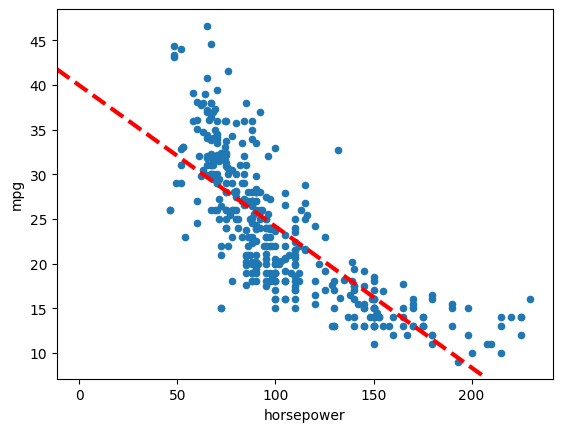

In [31]:
# Plot mpg vs horsepower
#mpg = auto['mpg']
#horsepower = auto['horsepower']

ax = auto.plot.scatter('horsepower', 'mpg')
ax.axline(
    xy1=(0, intercept), 
    slope=slope, 
    c='r', 
    linestyle='--', 
    linewidth=3
)
#ax.set_xlim(0, 250)

In [9]:
# Make predictions
design = MS(['horsepower'])
design = design.fit(auto)
new_df = pd.DataFrame({'horsepower': [98]})
newX = design.transform(new_df)
newX

,intercept,horsepower
0,1.0,98


In [10]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([24.46707715])

In [11]:
# 95% Confidence intervals (alpha = 0.05)
new_predictions.conf_int(alpha=0.05)

array([[23.97307896, 24.96107534]])

In [12]:
# 95% Prediction intervals (alpha = 0.05)
new_predictions.conf_int(obs=True, alpha=0.05)

array([[14.80939607, 34.12475823]])

In [18]:
4.906/23.4459

0.20924767230091398

# Diagnosis plots

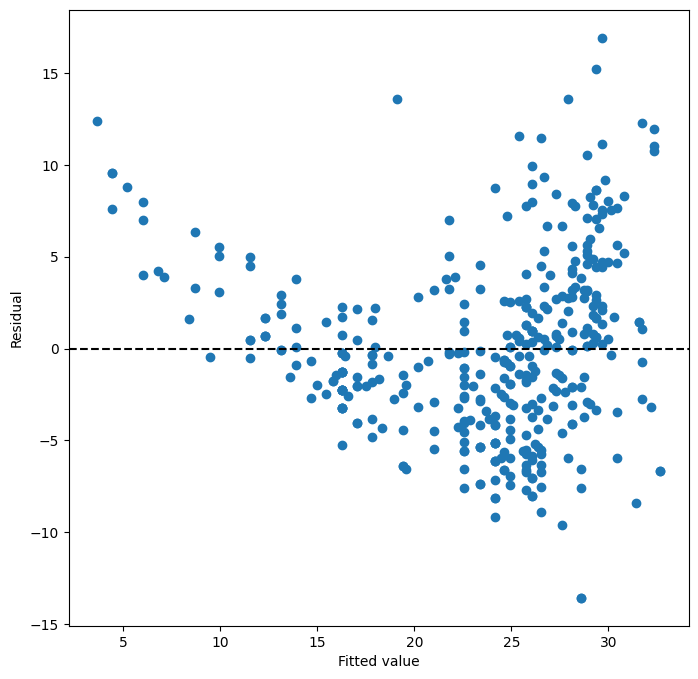

In [32]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

By looking at the plot of Residuals $e_i=y_i-\hat{y_i}$ vs Fitted values $\hat{y_i}$, there is evidence of non linearity.

115

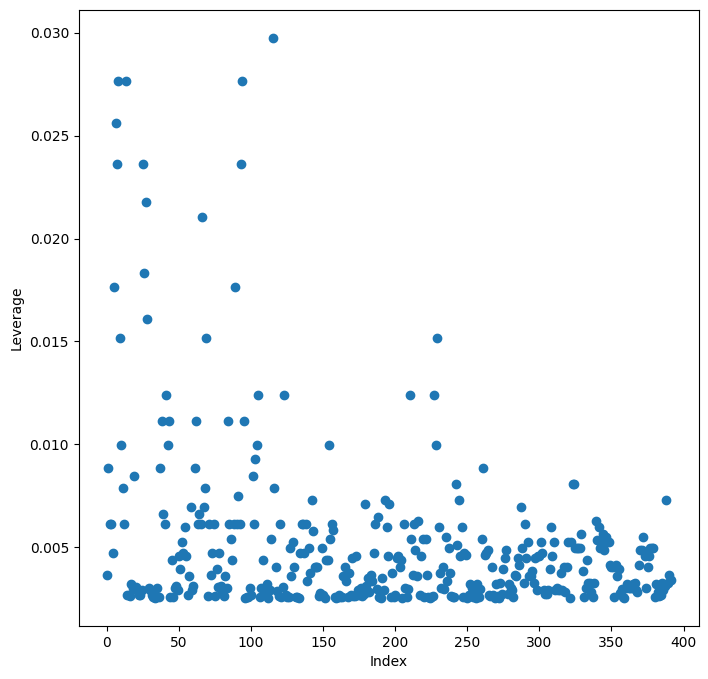

In [33]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)